In [1]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn  as nn
import pandas as pd
import numpy as np
import statistics
import torch

%matplotlib inline

In [2]:
########### Read the Data ###########
data = pd.read_csv('measurement.csv')
print(f'data.head: \n{data.head()}\nShape: {data.shape}')
n_rows = data.shape[0]

data.head: 
  ptime;time;windspeed [m/s];power [relative]
0    2019-11-01;2019-11-01 01:00:00;7.47;0.32
1    2019-11-01;2019-11-01 02:00:00;7.62;0.22
2    2019-11-01;2019-11-01 03:00:00;8.35;0.27
3    2019-11-01;2019-11-01 04:00:00;8.13;0.12
4    2019-11-01;2019-11-01 05:00:00;7.73;0.25
Shape: (1230, 1)


In [3]:
########### Create a useable dataframe ###########
''' 
    Each row of the dataset is something like this: "ptime;time;windspeed [m/s];power [relative] 2019-11-01;2019-11-01 01:00:00;7.47;0.32".
    1. We get the values of each row (i.e. "[2019-11-01;2019-11-01 01:00:00;7.47;0.32]").
    2. We drop the first column(value) of each row (i.e. 2019-11-01).
    3. We split the row into 3 parts (i.e. 2019-11-01 01:00:00, 7.47, 0.32).
    4. We create a dataframe of these rows.
'''
def create_dataframe(x:pd.DataFrame) -> list:
    rows = []

    for i in range(x.shape[0]):
        row_i = (x.loc[i].values).item()
        row_i = row_i.split(';')[1:]  
        rows.append(row_i)
    return rows

df = pd.DataFrame(np.array(create_dataframe(data)), columns=['time', 'speed', 'power'])

Without any further observation, my first assumption would be:

1)f(speed[i]) = power[i]

2)f(time[i], speed[i]) = power[i] 

3)f({ (time[i],speed[i]), (time[i-1],speed[i-1]), ... (time[i-k], speed[i-k]) }) = power[i] # f could be an RNN 

4)f({ speed[i], speed[i-1], ..., speed[i-k] }) = power[i] # f could be an RNN 



In [4]:
########### Preprocess the dataframe (1)###########

def preprocess(x:pd.DataFrame) -> None:
    x['time'] = pd.to_datetime(df['time'])
    x['speed'] = pd.to_numeric(df['speed'])
    x['power'] = pd.to_numeric(df['power'])

preprocess(df)




print(f'First timestamp: { df["time"].min()}, Last timestamp: {df["time"].max()}')
print(f'Interval: {df["time"].max() - df["time"].min()}')



# normalize the speed column (Min-Max normalization)
speed_max = df['speed'].max()
speed_min = df['speed'].min()
df['normalized_speed'] = (df['speed'] - speed_min) / (speed_max - speed_min)

print(df.describe())



First timestamp: 2019-11-01 01:00:00, Last timestamp: 2019-12-22 06:00:00
Interval: 51 days 05:00:00
             speed        power  normalized_speed
count  1230.000000  1230.000000       1230.000000
mean      6.277439     0.190943          0.368107
std       2.806720     0.199379          0.170001
min       0.200000     0.000000          0.000000
25%       4.250000     0.030000          0.245306
50%       6.310000     0.130000          0.370079
75%       8.227500     0.290000          0.486220
max      16.710000     1.050000          1.000000


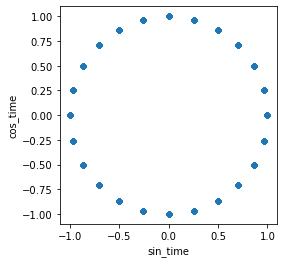

In [5]:
########### Preprocess the dataframe (2)###########
'''
    The timestamp interval is only 51 days. Thus, the day in which the measurment was performed may not be a valuable information.
    Though, the hour could be valuable because we have a lot of sample for each hour of a day.

    => Now, we will create a new column which contains only the hour of the timestamp
    Also we create two other columns called "cos_time" and "sin_time" because time is a 
    periodic continuous features (e.g. hour 23:00 must be close to hour 01:00)
    So, we'd transform hour to a unit circle. T(h) = (cos(alpha), sin(alpha))
'''
def hour2circle(x:pd.DataFrame)->None:
    x['hour'] = x['time'].dt.hour
    x['sin_time'] = np.sin(2*np.pi*x['time'].dt.hour/24)
    x['cos_time'] = np.cos(2*np.pi*x['time'].dt.hour/24)
    
hour2circle(df)


df.plot.scatter('sin_time','cos_time').set_aspect('equal')

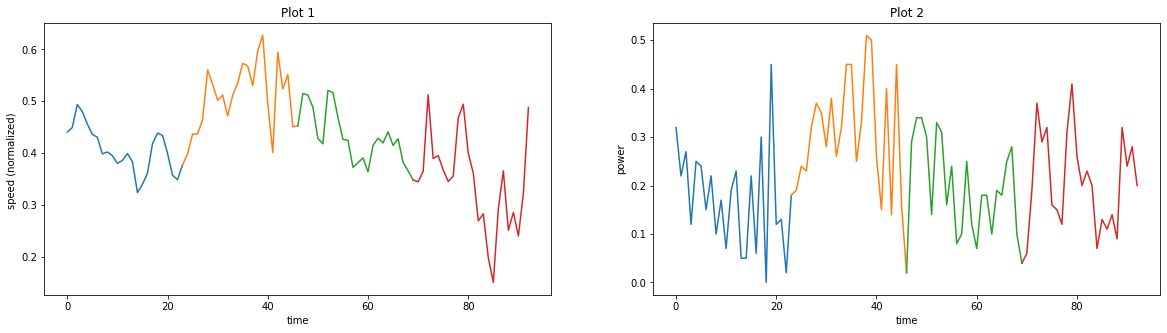

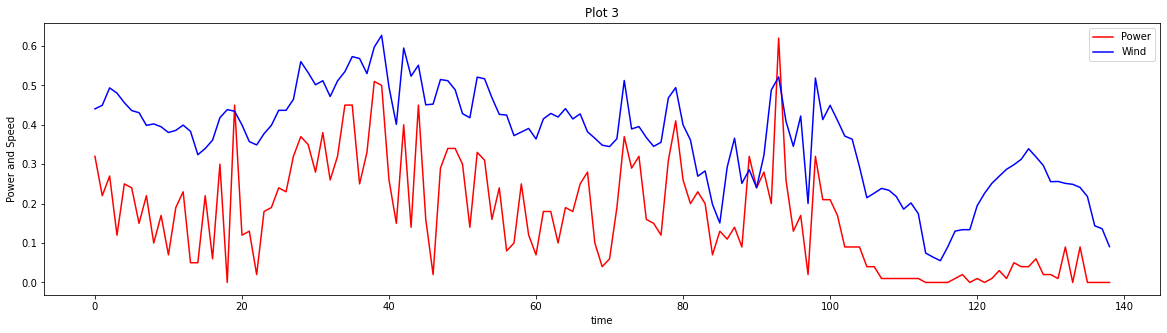

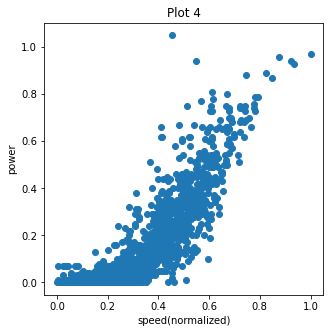

Correlation Matrix (speed, power):
          speed     power
speed  1.000000  0.835461
power  0.835461  1.000000


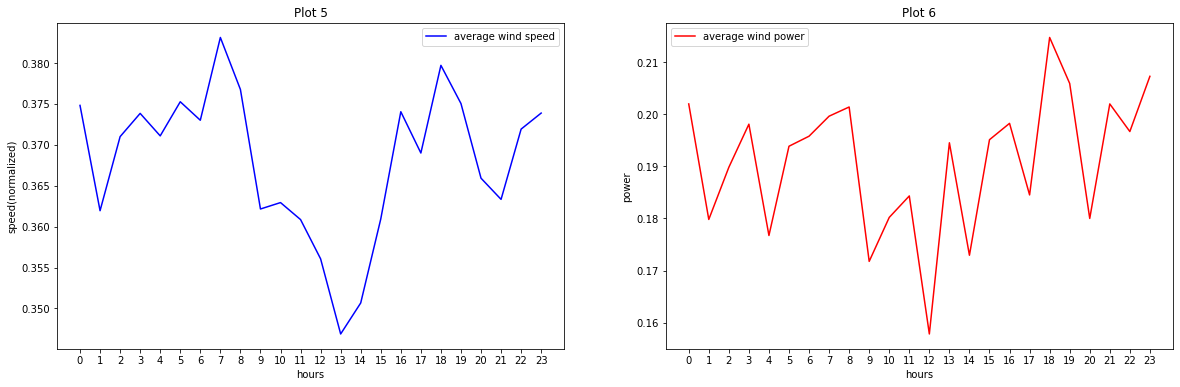

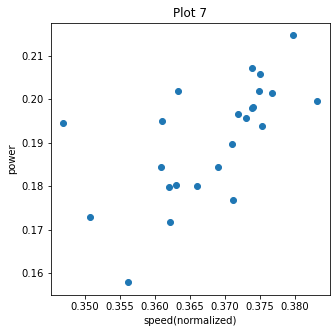

correlation between average-wind-speed and avgerage-wind-power in each hour:
0.6244580045538676


In [6]:
########### Visualization ###########
'''
    plots:
    1) x=time, y=speed (first 4 days)
    2) x=time, y=power (first 4 days)
    3) x=time, y1=speed, y2=power (first 4 days)
    4) x=speed, y=power
    5) x=hour, y=speed mean 
    6) x=hour, y=power mean
    7) x=spead mean, y=power mean
'''
########### plot 1,2 ###########
################################
# each color represents a specific day
# each plot shows speed/power of first 4 days
from cProfile import label


fig = plt.figure(figsize=(20,5))
s, e = 0, 23
ax = fig.add_subplot(1, 2, 1, )
for i in range(4):
    plt.plot(df.loc[s :e, 'normalized_speed'])
    s += 23
    e = s + 23
ax.set_title("Plot 1")
ax.set_xlabel("time")
ax.set_ylabel("speed (normalized) ")

s, e = 0, 23
ax =fig.add_subplot(1, 2, 2)

for i in range(4):
    
    plt.plot(df.loc[s :e, 'power'])
    s += 23
    e = s + 23

ax.set_title("Plot 2")
ax.set_xlabel("time")
ax.set_ylabel("power")
########### plot 3 ###########
##############################
# This plot depicts plot 1 and plot 2 in a same plot
plt.figure(figsize=(20,5))
    
plt.plot(df.loc[0 :138, 'power'], color='r', label='Power')
plt.plot(df.loc[0 :138, 'normalized_speed'], color='b', label="Wind")
plt.xlabel("time")
plt.ylabel("Power and Speed")
plt.title("Plot 3")
plt.legend()
plt.show()

########### plot 4 ###########
##############################
# power, speed plot
plt.figure(figsize=(5,5))
plt.scatter(x=df['normalized_speed'], y=df['power'])
plt.xlabel("speed(normalized)")
plt.ylabel("power") 
plt.title("Plot 4")
plt.show()

print(f'Correlation Matrix (speed, power):\n{df.loc[:, ["speed", "power"]].corr()}')
#####################################


########### plot 5 ###########
##############################
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1, 2, 1)
avg_speed_hour = df.groupby(df['hour'])['normalized_speed'].mean() 
plt.plot(avg_speed_hour, label = "average wind speed", color='b')
hours = np.arange(0, 24, 1)
plt.xticks(hours)
ax.set_xlabel("hours")
ax.set_ylabel("speed(normalized)")
ax.set_title("Plot 5")
plt.legend()

########### plot 6 ###########
##############################
ax = fig.add_subplot(1, 2, 2)
avg_power_hour = df.groupby(df['hour'])['power'].mean()
plt.plot(avg_power_hour, label = "average wind power", color='r')
hours = np.arange(0, 24, 1)
plt.xticks(hours)
ax.set_xlabel("hours")
ax.set_ylabel("power")
ax.set_title("Plot 6")
plt.legend()
plt.show()

########### plot 7 ###########
##############################

plt.figure(figsize=(5,5))
plt.scatter(x=avg_speed_hour, y=avg_power_hour)
plt.xlabel("speed(normalized)")
plt.ylabel("power") 
plt.title("Plot 7")
plt.show()

corr, _ = pearsonr(avg_speed_hour, avg_power_hour)
print(f'correlation between average-wind-speed and avgerage-wind-power in each hour:\n{corr}')
 

Observation from plot 1 - 4:
Wind speed and wind power have a strong positive correlation:0.83 (i.e. whenever wind-speed increases wind-power also increases)
But, as you can see in the plot_4, for the points with speed less than ~ 0.3, the correlation decreses significantly!
It is likely that when the wind speed is greater than a specific value it is strongly correlated with the wind-power, but the correlation decreses when the wind speed goes under a specific value. 
To-do:
1) we need to find this value (e.g. using binary search) and evaluates the correlation of both parts
2) if the two correlations differs significantly we need separate our data in 2 parts, and train them separatly (also we may need 2 models with different architecture)

Observation from plot 5-7:
plot 5 and 6 shows that on average at around 11-13 hour we have the lowest wind-power and wind speed.
Also around 6-8 and 18-19 hour we have high wind-power and wind-speed
But at some hours, e.g. 4 a.m. on average we have slightly high wind-power but slightly low wind-speed.
Plot 7, shows that these two variables are moderately correlated (>0.62).
conclusion: If this correlation was also strong like the one we observed in the plot 4, we could have ignored hour for the training process.
But, knowing the hour at which measurment was performed, may help our model to predict better.
To-do:
we need to train 2 models, one which only requires wind-speed as an input, and one which also requires the hour as an input. and measures the performance of two models, and select the best one with the lowest validation loss.

In [7]:
cutting_list = [0.35, 0.3, 0.25, 0.2, 0.185]
for cut in cutting_list:
     part1= df.loc[df['normalized_speed'] > cut].copy()
     part2 = df.loc[df['normalized_speed'] <= cut].copy()
     corr1 = part1.loc[:, ['normalized_speed', 'power']].corr()
     corr2 = part2.loc[:, ['normalized_speed', 'power']].corr() 
     print(f'cut: {cut}\ncorr1: {corr1}\ncorr2: {corr2}')
     print(f'number of samples in part1: {part1.shape[0]}')
     print(f'number of samples in part2: {part2.shape[0]}')
     print('****************************************')
     


cut: 0.35
corr1:                   normalized_speed     power
normalized_speed          1.000000  0.790633
power                     0.790633  1.000000
corr2:                   normalized_speed     power
normalized_speed          1.000000  0.475102
power                     0.475102  1.000000
number of samples in part1: 675
number of samples in part2: 555
****************************************
cut: 0.3
corr1:                   normalized_speed     power
normalized_speed          1.000000  0.819088
power                     0.819088  1.000000
corr2:                   normalized_speed     power
normalized_speed          1.000000  0.410246
power                     0.410246  1.000000
number of samples in part1: 802
number of samples in part2: 428
****************************************
cut: 0.25
corr1:                   normalized_speed     power
normalized_speed          1.000000  0.835443
power                     0.835443  1.000000
corr2:                   normalized_speed     power

mean of power: 0.013020833333333334


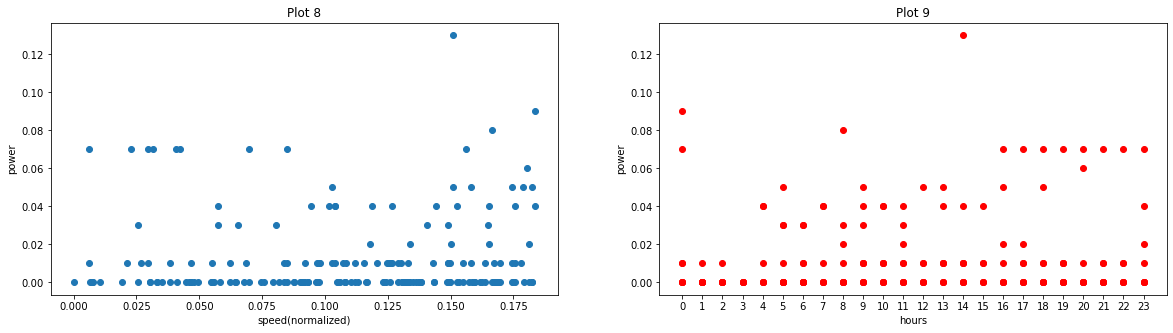

In [8]:
'''
    if we separate our dataset based on cutting-value = 0.185, then we would have 2 parts, 
    one with strong positive correlation(0.85), and one uncorrelated part with(0.05).
    we can plot the uncorrelated part and see whether we can observe anything interesting in that region or not.
    plot 8 : x=normalized speed , y= power
    plot 9 : x=hour, y=power (scatter)
'''

CUT = 0.185
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
part2 = df.loc[df['normalized_speed'] <= CUT]
plt.scatter(x=part2['normalized_speed'], y=part2['power'])
plt.xlabel("speed(normalized)")
plt.ylabel("power") 
plt.title("Plot 8")
ax = fig.add_subplot(1,2,2)
plt.scatter(x=part2['hour'], y=part2['power'], color='r')
hours = np.arange(0, 24, 1)
plt.xticks(hours)
ax.set_xlabel("hours")
ax.set_ylabel("power")
ax.set_title("Plot 9")

mean_power_part2 = part2['power'].mean()
print(f'mean of power: {mean_power_part2}')



Observation:
As you can see, the wind-power for at least half of the data of part 2 is equal to zero or close to zero (0.01)
The wind-speed and the hour have no effect on the wind-power of this half. 
For prediction of power:
If normalized_speed < CUT:
    power = mean_power_part2

Now we move on to the main part.

In [9]:
''' 
We split the data into train, and validation set 
'''
part1.reset_index(drop=True, inplace=True)
train_set, val_set = train_test_split(part1, test_size=0.2)
train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)
train_size = train_set.shape[0]
val_size = val_set.shape[0]
print(f'train size: {train_size}, validation_size: {val_size}')


train size: 830, validation_size: 208


In [10]:
'''
We define a simple model

W2*ReLU(W1*input)


'''


class net(nn.Module):
    def __init__(self, input_dim, hidden_size = 10) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.layers(x)

def weight_init(m):
    submodule_name = m.__class__.__name__
    if submodule_name.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 1)

In [11]:
''' 
    we will test several models:

    model_1 : f(speed)
    model_2 : f(speed, speed^2)
    model_3 : f(speed, speed^2, speed^3)
    model_4 : f(speed, speed^2, speed^3, cos_time, sin_time)

    Loss function should be Mean Squared Error
    We use Adam as our optimizer

'''
LR = 1e-4
MAX_EPOCHS = 30
hidden_dim = 10
loss_fn = nn.MSELoss()
model = net(input_dim = 5)
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.5, 0.999))
weight_init(model)




In [12]:
for epoch in range(MAX_EPOCHS):


    losses = []
    ######################################
    ############## Training ##############
    for i in range(train_size):
        optimizer.zero_grad()
        speed = train_set.loc[i, 'normalized_speed']
        cos_time = train_set.loc[i, 'cos_time']
        sin_time = train_set.loc[i, 'sin_time']
        power = train_set.loc[i, 'power']

        x = torch.tensor([speed, speed**2, speed**3, cos_time, sin_time], dtype=torch.float32, requires_grad=True)
        x = torch.unsqueeze(x, 0)

        y = torch.tensor([power], dtype=torch.float32)
        y = torch.unsqueeze(y, 0)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_train_loss = torch.tensor(losses).mean()

    #########################################
    ############## Validating  ##############
    model.eval()
    losses = []
    for i in range(val_size):
        with torch.no_grad():
            speed = val_set.loc[i, 'normalized_speed']
            cos_time = val_set.loc[i, 'cos_time']
            sin_time = val_set.loc[i, 'sin_time']
            power = val_set.loc[i, 'power']

            x = torch.tensor([speed, speed**2, speed**3, cos_time, sin_time], dtype=torch.float32, requires_grad=True)
            x = torch.unsqueeze(x, 0)

            y = torch.tensor([power], dtype=torch.float32)
            y = torch.unsqueeze(y, 0)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            losses.append(loss.item())

    avg_val_loss = torch.tensor(losses).mean()

    print(f'epoch: {epoch}, train_loss: {avg_train_loss}, val_loss: {avg_val_loss}')

    model.train()



        

epoch: 0, train_loss: 0.4733802080154419, val_loss: 0.3924490213394165
epoch: 1, train_loss: 0.20558881759643555, val_loss: 0.1853223592042923
epoch: 2, train_loss: 0.09624914824962616, val_loss: 0.10084498673677444
epoch: 3, train_loss: 0.057009682059288025, val_loss: 0.06647567451000214
epoch: 4, train_loss: 0.04061534255743027, val_loss: 0.0505276694893837
epoch: 5, train_loss: 0.03253166750073433, val_loss: 0.0422973558306694
epoch: 6, train_loss: 0.028086557984352112, val_loss: 0.03734951838850975
epoch: 7, train_loss: 0.025142893195152283, val_loss: 0.03393474221229553
epoch: 8, train_loss: 0.022878138348460197, val_loss: 0.03118162415921688
epoch: 9, train_loss: 0.020898379385471344, val_loss: 0.028790725395083427
epoch: 10, train_loss: 0.019038567319512367, val_loss: 0.02653658017516136
epoch: 11, train_loss: 0.017255373299121857, val_loss: 0.024426572024822235
epoch: 12, train_loss: 0.015628864988684654, val_loss: 0.02250170335173607
epoch: 13, train_loss: 0.014213685877621174

I trained all 4 models for 30 epochs
I got the lowest validation loss from model_4 after 30 epochs of training.

In [13]:
'''
Let's plot and see how our model is doing for validation set
'''
model.eval()
predicted_power = []
true_power = []
for i in range(val_size):
    with torch.no_grad():
        speed = val_set.loc[i, 'normalized_speed']
        cos_time = val_set.loc[i, 'cos_time']
        sin_time = val_set.loc[i, 'sin_time']
        power = val_set.loc[i, 'power']

        x = torch.tensor([speed, speed**2, speed**3, cos_time, sin_time], dtype=torch.float32, requires_grad=True)
        x = torch.unsqueeze(x, 0)

        y_pred = model(x)

        predicted_power.append(y_pred.item())
        true_power.append(power)
        
        
    

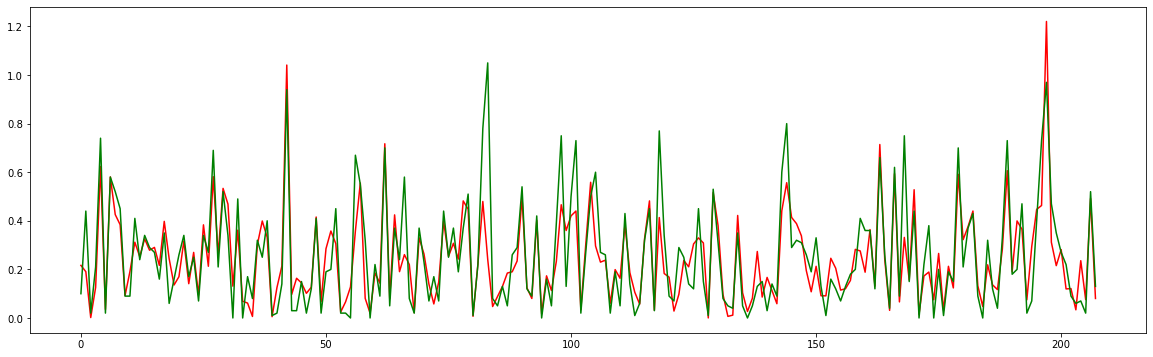

In [14]:
plt.figure(figsize=(20,6))
plt.plot(predicted_power , color='r')
plt.plot(true_power, color = 'g')

Observation:
after 30 epochs of training our model is able to forcast the wind-power pretty good!

In [15]:
''' 
At the end, we will evaluate our model with Test data (forecast.csv)
1) We load, and do all preprocessing step ** we should normalize speed based on max_speed and min_speed of previous dataframe (measurement.csv)
2) if normalized_speed < CUT : predicted_power = mean_power_part2
3) else power = model()
'''

test_data = pd.read_csv('forecast.csv')
df_test = pd.DataFrame(np.array(create_dataframe(test_data)), columns=['time', 'speed', 'power'])
preprocess(df_test)
df_test['normalized_speed'] = (df_test['speed'] - speed_min) / (speed_max - speed_min)
hour2circle(df_test)

print(df_test.describe())
n_rows_test = df_test.shape[0]



            speed       power  normalized_speed        hour      sin_time  \
count  270.000000  270.000000        270.000000  270.000000  2.700000e+02   
mean     5.637037    0.137444          0.329318   11.322222  1.591806e-02   
std      2.261732    0.131032          0.136992    6.963251  7.095514e-01   
min      0.970000    0.000000          0.046638    0.000000 -1.000000e+00   
25%      3.777500    0.020000          0.216687    5.000000 -7.071068e-01   
50%      5.850000    0.095000          0.342217   11.000000  1.224647e-16   
75%      7.395000    0.230000          0.435796   17.000000  7.071068e-01   
max     10.550000    0.620000          0.626893   23.000000  1.000000e+00   

           cos_time  
count  2.700000e+02  
mean   1.221436e-02  
std    7.070009e-01  
min   -1.000000e+00  
25%   -7.071068e-01  
50%    6.123234e-17  
75%    7.071068e-01  
max    1.000000e+00  


In [16]:

predicted_power = []
true_power = []
abs_error = []
model.eval()
for i in range(n_rows_test):

    speed = df_test.loc[i,'normalized_speed']
    power = df_test.loc[i, 'power']
    cos_time = df_test.loc[i, 'cos_time']
    sin_time = df_test.loc[i, 'sin_time']

    if speed < CUT:
        predicted_power.append(mean_power_part2)
        true_power.append(power)
        abs_error.append(abs(power - mean_power_part2))
        
    else:
        with torch.no_grad():
        
            x = torch.tensor([speed, speed**2, speed**3, cos_time, sin_time], dtype=torch.float32, requires_grad=True)
            x = torch.unsqueeze(x, 0)

            y_pred = model(x)

            predicted_power.append(y_pred.item())
            true_power.append(power)
            abs_error.append(abs(power - y_pred.item()))
        


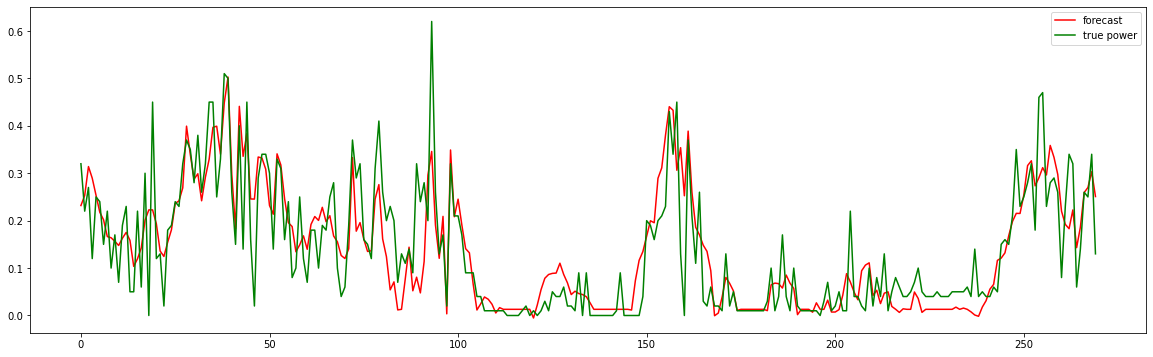

mean of errors: 0.052492659192762255
variance of errors: 0.0026649678991040094


In [17]:
plt.figure(figsize=(20,6))
plt.plot(predicted_power , color='r', label='forecast')
plt.plot(true_power, color = 'g', label='true power')
plt.legend()
plt.show()

print(f'mean of errors: {statistics.mean(abs_error)}')

print(f'variance of errors: {statistics.variance(abs_error)}')
